In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl

%matplotlib inline

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

transform = transforms.ToTensor()

data = datasets.SVHN(root = 'data/' , split = 'train' , download = True , transform = transform)
num_workers = 0
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset = data , batch_size = batch_size , shuffle = True , num_workers = num_workers)

Using downloaded and verified file: data/train_32x32.mat


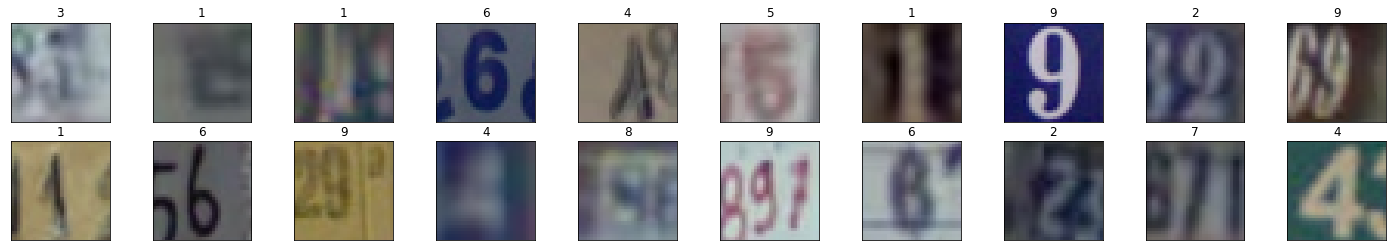

In [3]:
dataiter = next(iter(dataloader))
images , labels = dataiter

fig = plt.figure(figsize = (25,4))
plt_size = 20
for idx in range(plt_size):
    ax = fig.add_subplot(2,plt_size/2 , idx+1 , xticks =[],yticks= [])
    ax.imshow(np.transpose(images[idx],(1,2,0)))
    ax.set_title(str(labels[idx].item()))

In [4]:
#rescale feature_size range
def scale(x , feature_size = (-1,1)):
    min , max = feature_size
    x = x*(max-min)+min
    return x

In [5]:
import torch.nn.functional as F
import torch.nn as nn

In [6]:
#helper build convolution easier
def conv(in_channels , out_channels , kernel_size , stride = 2 , padding = 1 , batch_norm = True):
    layer = []
    
    conv_layer = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias = False)
    layer.append(conv_layer)
    if batch_norm:
        batchnorm = nn.BatchNorm2d(out_channels)
        layer.append(batchnorm)
    return nn.Sequential(*layer)

In [7]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3,conv_dim,4,batch_norm=False)
        #16 x 16 and no BatchNormalize out
        self.conv2 = conv(conv_dim,conv_dim*2,4)
        # 8 x 8 out
        self.conv3 = conv(conv_dim*2,conv_dim*4,4)
        # 4 x 4 out
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        
    def forward(self,x):
        #all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.conv2(x),0.2)
        x = F.leaky_relu(self.conv3(x),0.2)
        #flatten
        x = x.view(-1,self.conv_dim*4*4*4)
        
        x = self.fc(x)
        return x

In [8]:
def deconv(in_channel,out_channel,kernel_size,stride=2,padding = 1 ,batch_norm = True):
    
    layer=[]
    
    deconv_layer = nn.ConvTranspose2d(in_channel,out_channel,kernel_size,stride,padding,bias = False)
    layer.append(deconv_layer)
    
    if batch_norm:
        batchnorm = nn.BatchNorm2d(out_channel)
        layer.append(batchnorm)
        
    #using sequential container    
    return nn.Sequential(*layer)

In [9]:
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim):
        super(Generator,self).__init__()
        
        self.conv_dim = conv_dim
        self.z_size = z_size
        
        self.fc = nn.Linear(z_size,conv_dim*4*4*4)
        
        #transpose conv layers
        self.t_conv1 = deconv(conv_dim*4,conv_dim*2,4)
        self.t_conv2 = deconv(conv_dim*2,conv_dim,4)
        self.t_conv3 = deconv(conv_dim,3,4,batch_norm = False)
        
    def forward(self,x):
        
        x = self.fc(x)
        
        #reshape
        x = x.view(-1,self.conv_dim*4,4,4)
        
        #hidden layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        #last layer + tanh
        x = self.t_conv3(x)
        x = F.tanh(x)
        return x

In [10]:
#set hyperparameters
z_size = 100
conv_dim = 32

#define discriminator and generator
D = Discriminator(conv_dim = conv_dim)
G = Generator(z_size = z_size , conv_dim = conv_dim)
print(D)
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

In [11]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    G.cuda()
    D.cuda()
    print('Training will on GPU')
else:
    print('Training will on CPU')

Training will on GPU


In [12]:
def real_loss(D_out,smooth=False):
    
    batch_size = D_out.size(0)
    #labels smoothing and set labels = 1
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    if train_on_gpu:
        labels = labels.cuda()
    
    #binary cross entropy with logits loss 
    criterion = nn.BCEWithLogitsLoss()
    #calculate loss
    loss = criterion(D_out.squeeze(),labels)
    
    return loss

def fake_loss(D_out):
    
    batch_size = D_out.size(0)
    #fake labels = 0
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    
    return loss

In [13]:
import torch.optim as optim
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 #default value

#set discriminator and generator optimizer
G_optimizer = optim.Adam(G.parameters() , lr , [beta1,beta2])
D_optimizer = optim.Adam(D.parameters() , lr , [beta1,beta2])

In [14]:
epochs = 50

losses = []
sample = []
sample_size = 16
#define fixed_z will to test result of network training
fixed_z = np.random.uniform(-1,1,size = (sample_size,z_size))
fixed_z = torch.from_numpy(fixed_z).float()

every_print = 500

for E in range(epochs):
    for batch_i , (real_images , _) in enumerate(dataloader):
        
        batch_size = real_images.size(0)
        real_images = scale(real_images)
               
        
        #=====================       
        # train discriminator
        #===================== 
        D_optimizer.zero_grad()
        
        if train_on_gpu:
            real_images = real_images.cuda()
            
        #compute discriminator loss on real images
        real_output = D(real_images)
        d_real_loss = real_loss(real_output)    
        
        #generator fake images
        z = np.random.uniform(-1,1,size = (sample_size,z_size))
        z = torch.from_numpy(z).float()
        
        if train_on_gpu:
            z = z.cuda()
            
        fake_images = G(z)
        
        #compute discriminator loss on fake images     
        fake_output = D(fake_images)
        d_fake_loss = fake_loss(fake_output)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_optimizer.step()
        
        
        #=====================
        # train generator
        #=====================
        G_optimizer.zero_grad()
        
        #Generate fake images
        z = np.random.uniform(-1,1,size = (sample_size,z_size))
        z = torch.from_numpy(z).float()
        
        if train_on_gpu:
            z = z.cuda()
            
        fake_images = G(z)

        #compute generator loss on fake image
        g_fake_out = D(fake_images)
        g_loss = real_loss(g_fake_out)
        
        g_loss.backward()
        G_optimizer.step()
        
        if batch_i % every_print == 0:
            losses.append((d_loss.item(),g_loss.item()))
            print('Epochs: %s / %s , d_loss:%.5f , g_loss:%.5f' % (E+1,epochs,d_loss.item(),g_loss.item()))
            
    G.eval()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    sample_z = G(fixed_z)
    sample.append(sample_z)
    G.train()
    
with open('train_result.pkl','wb') as f:
    pkl.dump(sample,f)

Epochs: 1 / 50 , d_loss:1.46796 , g_loss:0.77508
Epochs: 1 / 50 , d_loss:0.51795 , g_loss:1.44360
Epochs: 2 / 50 , d_loss:0.64582 , g_loss:2.53208
Epochs: 2 / 50 , d_loss:1.12433 , g_loss:1.44574
Epochs: 3 / 50 , d_loss:0.93351 , g_loss:1.34386
Epochs: 3 / 50 , d_loss:0.73195 , g_loss:1.88499
Epochs: 4 / 50 , d_loss:1.18669 , g_loss:1.85333
Epochs: 4 / 50 , d_loss:0.68205 , g_loss:1.61848
Epochs: 5 / 50 , d_loss:1.11594 , g_loss:1.67868
Epochs: 5 / 50 , d_loss:0.26821 , g_loss:2.20430
Epochs: 6 / 50 , d_loss:1.07530 , g_loss:2.39309
Epochs: 6 / 50 , d_loss:0.90534 , g_loss:3.17523
Epochs: 7 / 50 , d_loss:0.79992 , g_loss:2.03909
Epochs: 7 / 50 , d_loss:0.26875 , g_loss:1.27777
Epochs: 8 / 50 , d_loss:0.47301 , g_loss:2.05054
Epochs: 8 / 50 , d_loss:0.43165 , g_loss:2.78268
Epochs: 9 / 50 , d_loss:0.30669 , g_loss:1.73963
Epochs: 9 / 50 , d_loss:0.30337 , g_loss:3.08674
Epochs: 10 / 50 , d_loss:0.30030 , g_loss:1.00091
Epochs: 10 / 50 , d_loss:0.36944 , g_loss:0.85472
Epochs: 11 / 50 , 

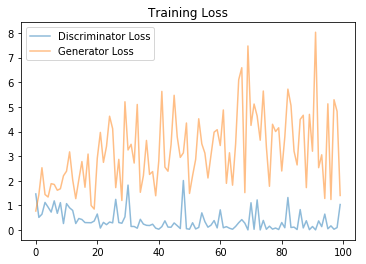

In [16]:
fig , ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0],label = 'Discriminator Loss' , alpha = 0.5)
plt.plot(losses.T[1],label = 'Generator Loss' , alpha = 0.5)
plt.title('Training Loss')
plt.legend()

In [24]:
def view_sample(epochs,sample):
    fig , axe = plt.subplots(figsize = (16,4) , nrows = 2 , ncols = 8 , sharex = True , sharey = True)
    for ax , img in zip(axe.flatten(),sample[epochs]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img,(1,2,0))
        img = ((img+1)*255/2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img.reshape(32,32,3))
    

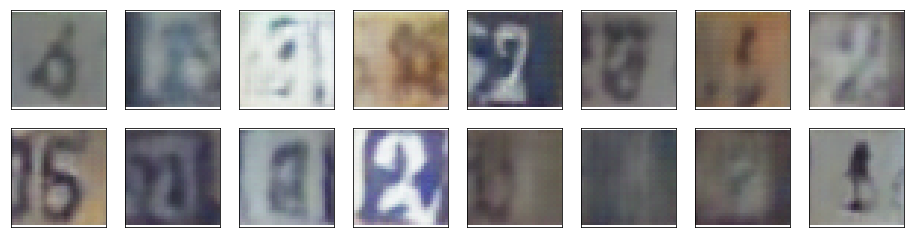

In [25]:
view_sample(-1,sample)